# Does player's sprints correlate to TotalxG?

# Correlation to xG

**Import dependencies and prepare dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
import graphviz

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

import statsmodels.api as sm
import shap

In [ ]:
full_games_dataset = pd.read_csv("/content/full_games_features_dataset.csv")
full_games_dataset = full_games_dataset.drop(['game_date','interval_duration'],axis=1)
full_games_dataset = full_games_dataset.reset_index(drop=True)

In [ ]:
X = full_games_dataset.drop(columns=['TotalxG'])
y = full_games_dataset['TotalxG']
print(y.describe())
scaler = StandardScaler()

count    61.000000
mean      1.977705
std       0.850354
min       0.510000
25%       1.350000
50%       1.710000
75%       2.470000
max       4.200000
Name: TotalxG, dtype: float64


## Linear correlation

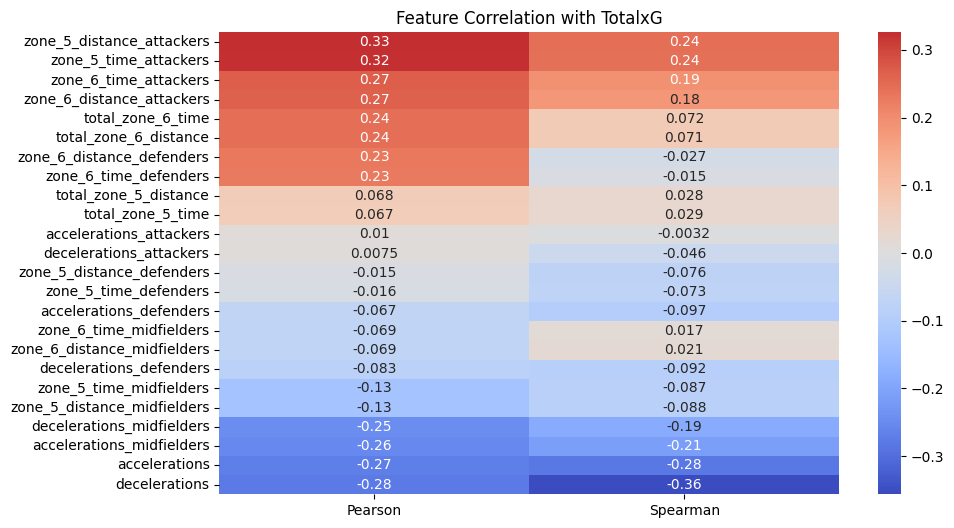

In [ ]:
# Pearson correlation
pearson_corr = X.corrwith(y)
spearman_corr = X.corrwith(y, method='spearman')
plt.figure(figsize=(10, 6))

# Combine Pearson and Spearman into a DataFrame and plot heatmap
corr_df = pd.DataFrame({
    'Pearson': pearson_corr,
    'Spearman': spearman_corr
})
sorted_features_corr = corr_df.reindex(corr_df['Pearson'].sort_values(ascending=False).index)
sns.heatmap(sorted_features_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlation with TotalxG")
plt.show()



We can observe that there is a significant positive correlation in both matrics between attackers sprints to total xG.
Also, in both matrics, there is a negative correlation between deceleration, especially midfilders decelerations to total xG which can point on a new thesis we didn't think about before.

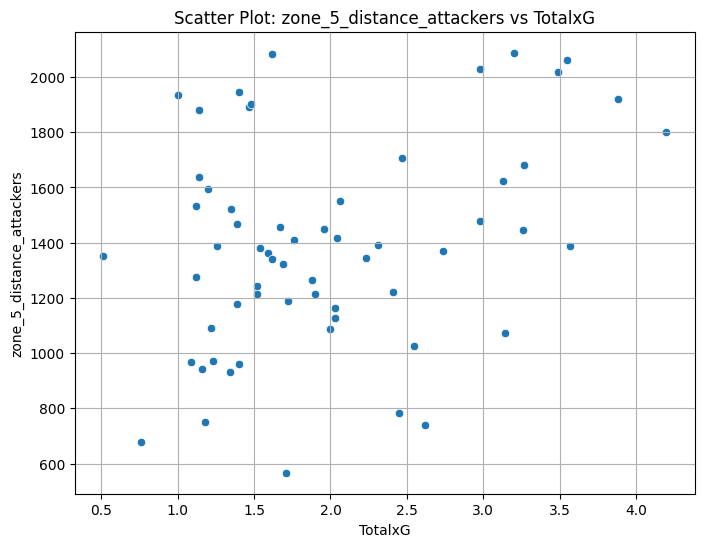

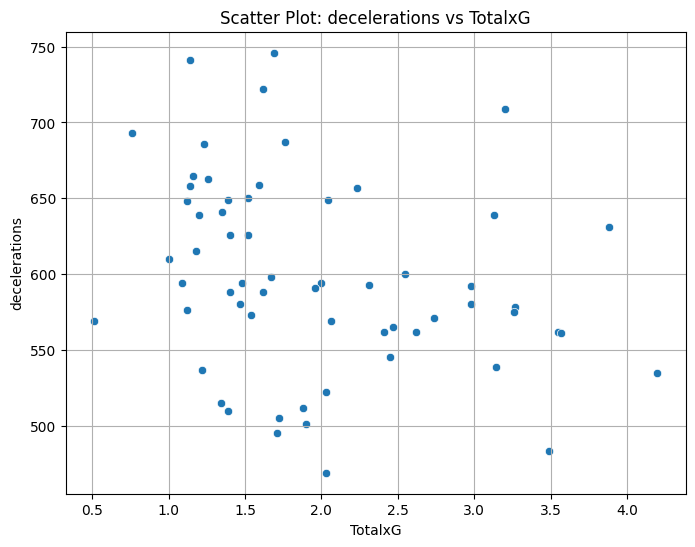

In [ ]:
def plot_scatter(df, target_col, variable_col):
    """
    Generates a scatter plot between the target column and a specified variable column.

    Args:
        df: pandas DataFrame.
        target_col: Name of the target column.
        variable_col: Name of the variable column to plot against the target.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=target_col, y=variable_col)
    plt.title(f'Scatter Plot: {variable_col} vs {target_col}')
    plt.xlabel(target_col)
    plt.ylabel(variable_col)
    plt.grid(True)
    plt.show()

plot_scatter(full_games_dataset, 'TotalxG', 'zone_5_distance_attackers')
plot_scatter(full_games_dataset, 'TotalxG', 'decelerations')


## Mutual Information

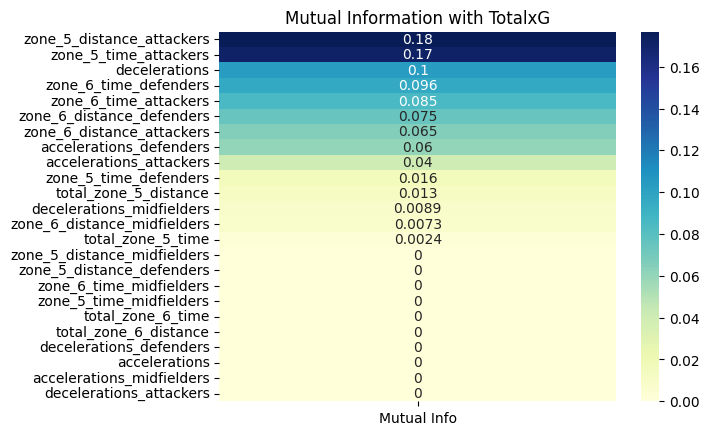

In [ ]:
# Mutual Information (non-linear dependency)
mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=X.columns)
sorted_mi = mi_series.sort_values(ascending=False)
sns.heatmap(sorted_mi.to_frame(name='Mutual Info'), annot=True, cmap="YlGnBu")
plt.title("Mutual Information with TotalxG")
plt.show()

This approach is able to catch non linear relations between features to the target, this metric strengthens our thesis about the relation between zone 5/6 sprints to total xG, especially attackers sprints.

## Least Squares coefficients and P-values

In [ ]:
cols_to_drop = [col for col in full_games_dataset.columns if 'distance' in col or 'total' in col]
X = X.drop(columns=cols_to_drop)
X = X.drop(['accelerations','decelerations'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
model = sm.OLS(y, sm.add_constant(X_scaled))
results = model.fit()

# Create a summary table
coef_df = pd.DataFrame({
    'Feature': ['const'] + list(X.columns), # Add 'const' to the feature list
    'Coefficient': round(results.params,3),
    'P-value': round(results.pvalues,5)
}).sort_values(by='Coefficient', key=lambda x: np.abs(x), ascending=False)

coef_df




,Feature,Coefficient,P-value
const,const,1.978,0.00000
zone_5_time_attackers,zone_5_time_attackers,0.410,0.02457
accelerations_midfielders,accelerations_midfielders,-0.338,0.16181
accelerations_attackers,accelerations_attackers,-0.294,0.32812
zone_6_time_defenders,zone_6_time_defenders,0.238,0.67191
decelerations_defenders,decelerations_defenders,-0.176,0.35535
zone_6_time_midfielders,zone_6_time_midfielders,0.162,0.39830
zone_5_time_midfielders,zone_5_time_midfielders,-0.154,0.46170
zone_6_time_attackers,zone_6_time_attackers,-0.133,0.82173
zone_5_time_defenders,zone_5_time_defenders,-0.084,0.63369


## Random Forest

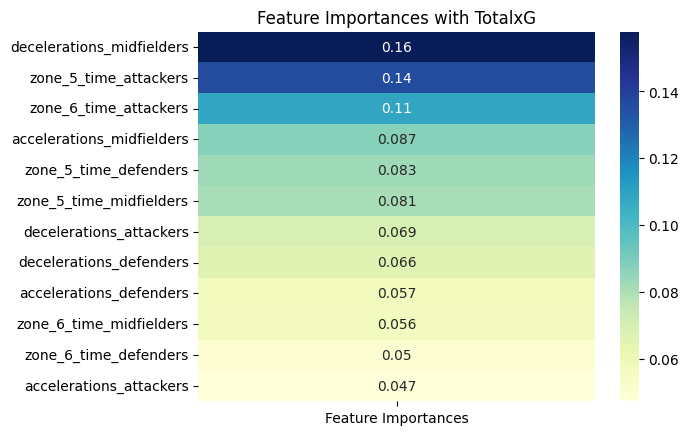

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42,max_features=6)
rf.fit(X_train, y_train.to_numpy().ravel())

rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
sorted_importance = rf_importances.sort_values(ascending=False)
sns.heatmap(sorted_importance.to_frame(name='Feature Importances'), annot=True, cmap="YlGnBu")
plt.title("Feature Importances with TotalxG")
plt.show()

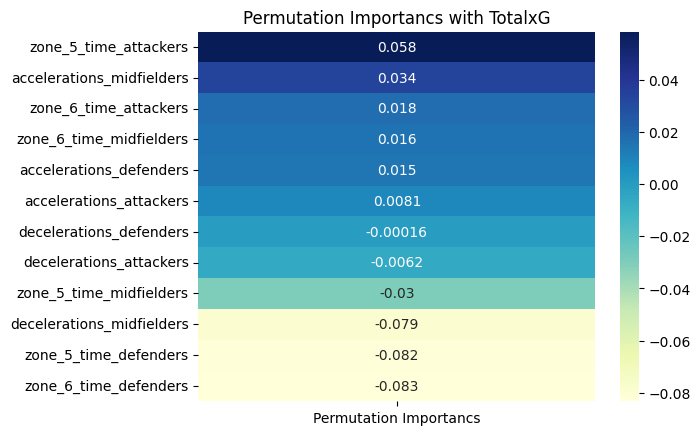

In [ ]:
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_series = pd.Series(perm_importance.importances_mean, index=X.columns).sort_values(ascending=False)

sorted_importance = perm_importance_series.sort_values(ascending=False)
sns.heatmap(sorted_importance.to_frame(name='Permutation Importancs'), annot=True, cmap="YlGnBu")
plt.title("Permutation Importancs with TotalxG")
plt.show()

## SHAP analysis

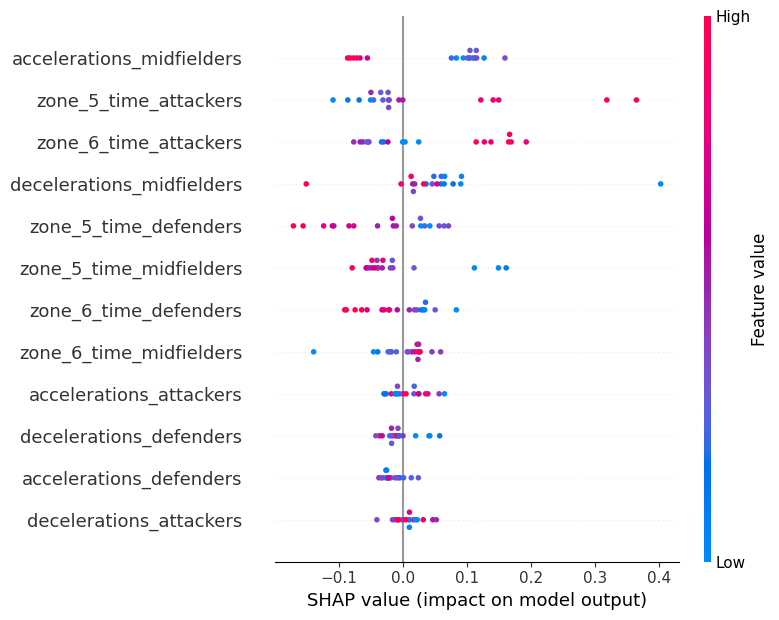

In [ ]:
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)  # explain on test set

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)

## Summary

In [ ]:
combined_df = pd.DataFrame({
    'Pearson': pearson_corr,
    'Spearman': spearman_corr,
    'Mutual_Info': mi_series,
    'Linear_Coefficient': coef_df.set_index('Feature').loc[X.columns, 'Coefficient'],
    'P-value': coef_df.set_index('Feature').loc[X.columns, 'P-value'],
    'RF_Importance': rf_importances,
    'Permutation_Importance': perm_importance_series
})

# Round values for readability
combined_df[['Pearson','Spearman','Mutual_Info','Linear_Coefficient','P-value',
             'RF_Importance','Permutation_Importance']] = combined_df[[
    'Pearson','Spearman','Mutual_Info','Linear_Coefficient','P-value',
    'RF_Importance','Permutation_Importance'
]].round(4)

# Sort by absolute Permutation Importance (validated)
combined_df = combined_df.reindex(
    combined_df['Permutation_Importance'].abs().sort_values(ascending=False).index
)

combined_df

,Pearson,Spearman,Mutual_Info,Linear_Coefficient,P-value,RF_Importance,Permutation_Importance
zone_6_time_defenders,0.2290,-0.0150,0.0964,0.238,0.6719,0.0501,-0.0833
zone_5_time_defenders,-0.0156,-0.0728,0.0163,-0.084,0.6337,0.0830,-0.0824
decelerations_midfielders,-0.2454,-0.1865,0.0089,0.071,0.7476,0.1579,-0.0790
zone_5_time_attackers,0.3224,0.2416,0.1712,0.410,0.0246,0.1363,0.0585
accelerations_midfielders,-0.2550,-0.2104,0.0000,-0.338,0.1618,0.0872,0.0337
zone_5_time_midfielders,-0.1279,-0.0872,0.0000,-0.154,0.4617,0.0806,-0.0298
zone_6_time_attackers,0.2687,0.1931,0.0854,-0.133,0.8217,0.1088,0.0178
zone_6_time_midfielders,-0.0692,0.0165,0.0000,0.162,0.3983,0.0564,0.0155
accelerations_defenders,-0.0669,-0.0967,0.0603,0.045,0.8201,0.0570,0.0151
accelerations_attackers,0.0105,-0.0032,0.0401,-0.294,0.3281,0.0473,0.0081


# Correlation to opponent team xG

In [ ]:
full_games_dataset = pd.read_csv("/content/full_games_features_dataset3.csv")
full_games_dataset = full_games_dataset.drop(['game_date','interval_duration','TotalxG','xG_diff'],axis=1)
full_games_dataset = full_games_dataset.reset_index(drop=True)

In [ ]:
X = full_games_dataset.drop(columns=['opponent_team_xG'])
y = full_games_dataset['opponent_team_xG']
scaler = StandardScaler()

## Linear correlation

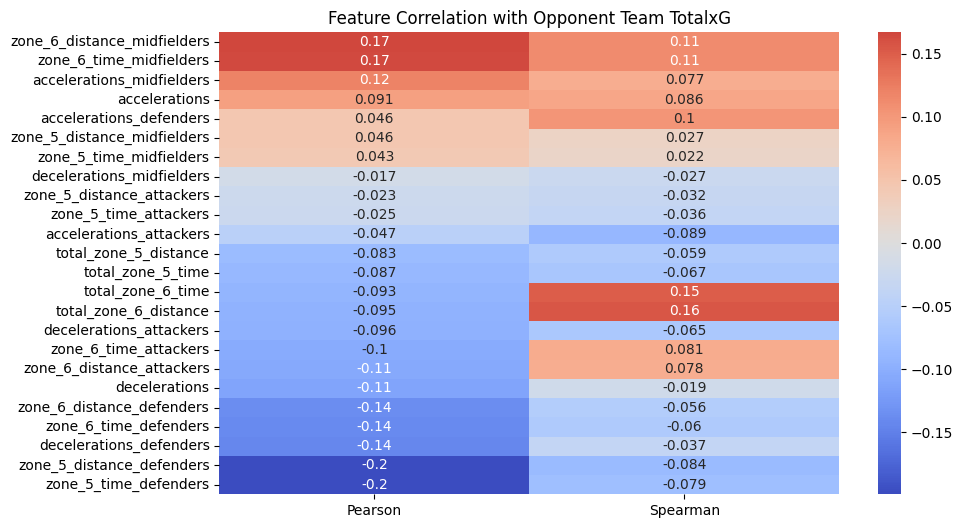

In [ ]:
# Pearson correlation
pearson_corr = X.corrwith(y)
spearman_corr = X.corrwith(y, method='spearman')
plt.figure(figsize=(10, 6))

# Combine Pearson and Spearman into a DataFrame and plot heatmap
corr_df = pd.DataFrame({
    'Pearson': pearson_corr,
    'Spearman': spearman_corr
})
sorted_features_corr = corr_df.reindex(corr_df['Pearson'].sort_values(ascending=False).index)
sns.heatmap(sorted_features_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlation with Opponent Team TotalxG")
plt.show()



## Mutual Information

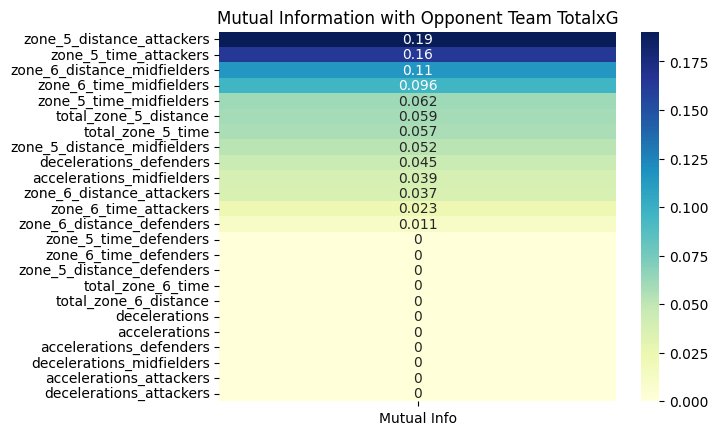

In [ ]:
# Mutual Information (non-linear dependency)
mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=X.columns)
sorted_mi = mi_series.sort_values(ascending=False)
sns.heatmap(sorted_mi.to_frame(name='Mutual Info'), annot=True, cmap="YlGnBu")
plt.title("Mutual Information with Opponent Team TotalxG")
plt.show()

## Least Squares coefficients and P-values

In [ ]:
cols_to_drop = [col for col in full_games_dataset.columns if 'distance' in col or 'total' in col]
X = X.drop(columns=cols_to_drop)
X = X.drop(['accelerations','decelerations','zone_6_time_attackers','zone_6_time_defenders'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
model = sm.OLS(y, sm.add_constant(X_scaled))
results = model.fit()

# Create a summary table
coef_df = pd.DataFrame({
    'Feature': ['const'] + list(X.columns), # Add 'const' to the feature list
    'Coefficient': round(results.params,3),
    'P-value': round(results.pvalues,5)
}).sort_values(by='Coefficient', key=lambda x: np.abs(x), ascending=False)

coef_df




,Feature,Coefficient,P-value
const,const,1.023,0.00000
zone_6_time_midfielders,zone_6_time_midfielders,0.349,0.04934
zone_5_time_midfielders,zone_5_time_midfielders,-0.270,0.16097
accelerations_defenders,accelerations_defenders,0.261,0.08463
accelerations_attackers,accelerations_attackers,-0.203,0.33644
decelerations_defenders,decelerations_defenders,-0.202,0.27192
zone_5_time_defenders,zone_5_time_defenders,-0.169,0.14039
decelerations_attackers,decelerations_attackers,0.124,0.56374
zone_5_time_attackers,zone_5_time_attackers,0.068,0.59846
decelerations_midfielders,decelerations_midfielders,0.048,0.82233


## Random Forest

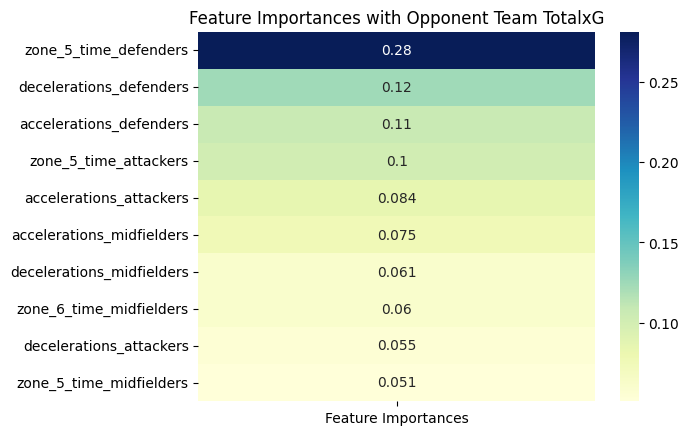

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42,max_features=6)
rf.fit(X_train, y_train.to_numpy().ravel())

rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
sorted_importance = rf_importances.sort_values(ascending=False)
sns.heatmap(sorted_importance.to_frame(name='Feature Importances'), annot=True, cmap="YlGnBu")
plt.title("Feature Importances with Opponent Team TotalxG")
plt.show()

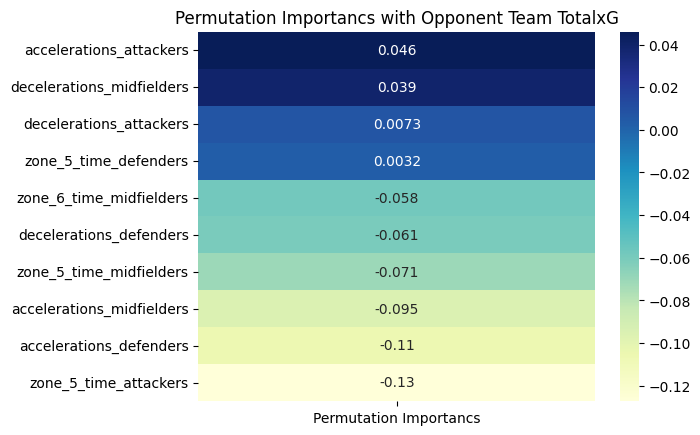

In [ ]:
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_series = pd.Series(perm_importance.importances_mean, index=X.columns).sort_values(ascending=False)

sorted_importance = perm_importance_series.sort_values(ascending=False)
sns.heatmap(sorted_importance.to_frame(name='Permutation Importancs'), annot=True, cmap="YlGnBu")
plt.title("Permutation Importancs with Opponent Team TotalxG")
plt.show()

## SHAP analysis

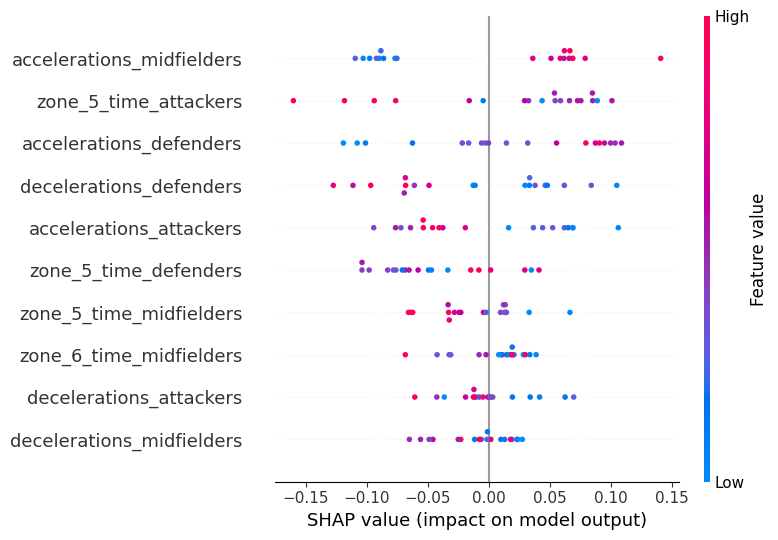

In [ ]:
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)  # explain on test set

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)

## Summary

In [ ]:
combined_df = pd.DataFrame({
    'Pearson': pearson_corr,
    'Spearman': spearman_corr,
    'Mutual_Info': mi_series,
    'Linear_Coefficient': coef_df.set_index('Feature').loc[X.columns, 'Coefficient'],
    'P-value': coef_df.set_index('Feature').loc[X.columns, 'P-value'],
    'RF_Importance': rf_importances,
    'Permutation_Importance': perm_importance_series
})

# Round values for readability
combined_df[['Pearson','Spearman','Mutual_Info','Linear_Coefficient','P-value',
             'RF_Importance','Permutation_Importance']] = combined_df[[
    'Pearson','Spearman','Mutual_Info','Linear_Coefficient','P-value',
    'RF_Importance','Permutation_Importance'
]].round(4)

# Sort by absolute Permutation Importance (validated)
combined_df = combined_df.reindex(
    combined_df['Permutation_Importance'].abs().sort_values(ascending=False).index
)

combined_df

,Pearson,Spearman,Mutual_Info,Linear_Coefficient,P-value,RF_Importance,Permutation_Importance
zone_5_time_attackers,-0.0247,-0.0363,0.1640,0.068,0.5985,0.1008,-0.1273
accelerations_defenders,0.0463,0.1029,0.0000,0.261,0.0846,0.1072,-0.1062
accelerations_midfielders,0.1206,0.0772,0.0385,-0.039,0.8493,0.0753,-0.0950
zone_5_time_midfielders,0.0431,0.0217,0.0616,-0.270,0.1610,0.0509,-0.0708
decelerations_defenders,-0.1438,-0.0373,0.0449,-0.202,0.2719,0.1243,-0.0606
zone_6_time_midfielders,0.1650,0.1120,0.0957,0.349,0.0493,0.0600,-0.0578
accelerations_attackers,-0.0470,-0.0892,0.0000,-0.203,0.3364,0.0844,0.0460
decelerations_midfielders,-0.0174,-0.0267,0.0000,0.048,0.8223,0.0607,0.0387
decelerations_attackers,-0.0962,-0.0645,0.0000,0.124,0.5637,0.0549,0.0073
zone_5_time_defenders,-0.1990,-0.0787,0.0000,-0.169,0.1404,0.2814,0.0032
